# 🫀Procesamiento y Análisis de Señales ECG
--- 
Este notebook implementa un pipeline avanzado para el procesamiento, delineado y análisis cuantitativo de señales electrocardiográficas (ECG), incluyendo:

- Carga y visualización de señales reales provenientes de un dataset clínico compuesto por 17 clases de ritmos cardíacos. Para el desarrollo de esta actividad, se selecciona formalmente una única clase y una señal específica (una fila del registro correspondiente) para su análisis detallado.
- Detección de ondas P mediante filtrado pasabanda, descomposición wavelet y análisis del sobreenvolvente, complementado con un segundo método automático proporcionado por *NeuroKit2*.
- Detección de complejos QRS y picos R mediante un algoritmo personalizado fundamentado en derivadas sucesivas, medidas de energía, promediado móvil y un esquema de umbralización adaptativa.
- Delineación del complejo QRS utilizando el método DWT proporcionado por *NeuroKit2*, con el fin de estimar de manera robusta los onsets, offsets, duraciones y amplitudes.
- Detección de ondas T y cálculo de métricas morfológicas, incluyendo duración, amplitud y el intervalo TpTe.

En conjunto, este notebook constituye un marco metodológico integral para la identificación y caracterización morfológica de las ondas P, QRS y T en una señal ECG seleccionada del dataset.

## 📚Importación de librerías 
---
Importamos todas las librerías necesarias para el análisis de señales ECG: 

- **neurokit2**: Procesamiento avanzado de señales fisiológicas y detección automática de componentes ECG.
- **numpy**: Operaciones numéricas, manejo de arreglos y cálculos vectorizados.
- **scipy.signal**: Filtrado digital, detección de picos y análisis basado en métodos clásicos de procesamiento de señales.
- **matplotlib.pyplot**: Visualización de señales, gráficos comparativos y representación de resultados.
- **pickle**: Almacenamiento y carga de objetos en formato binario para gestionar datos procesados.
- **pywt**: Transformada wavelet discreta aplicada al análisis multiescala y delineado morfológico de la señal ECG.


In [462]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from scipy.signal import butter, filtfilt, find_peaks, hilbert, peak_widths
import pywt


Mar de dudas

In [463]:
path_db = r"C:\Users\DELL\Desktop\Señales\LAB-EKG-PROCESSING\LAB-EKG-PROCESSING\ECG_DATASET\dataset_ekg.pkl"
with open(path_db, "rb") as f:
    dataset = pickle.load(f)


ecg_signal = dataset["NSR"][1,:]

# Detección de la onda P usando neurokit2
fs = 360
t = np.arange(ecg_signal.shape[0]) / fs 

asasa

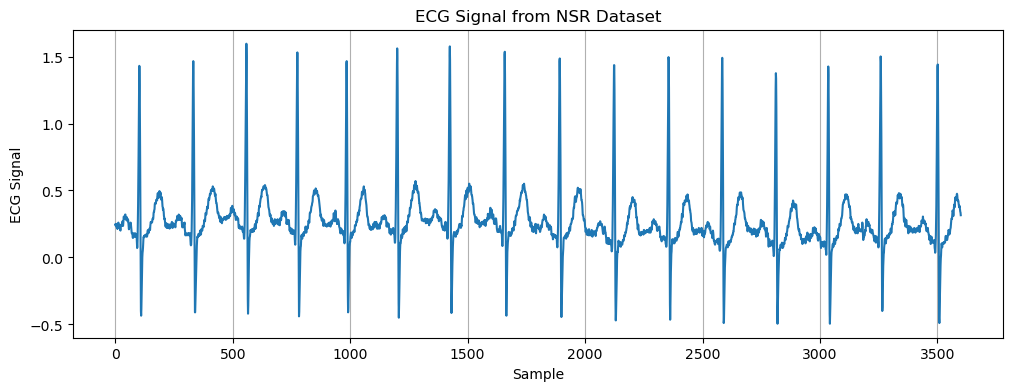

In [464]:
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal)
plt.xlabel("Sample")
plt.ylabel("ECG Signal")
plt.title("ECG Signal from NSR Dataset")
plt.grid(axis='x')

mar 

In [465]:
def detect_pwaves_only(ecg, fs, r_peaks=None):
    """
    Detect P-wave peaks without requiring R-peak anchors.
    Optional: supply r_peaks to reject events too close to QRS.
    Returns:
      p_idx: sample indices of P-wave peaks
      p_env: envelope used for detection (for plotting/QA)
    """
    x_bp, x_p, env = enhance_p_band(ecg, fs)

    # Adaptive threshold on the envelope
    thr = robust_thr(env, k=2.0)

    # Physiologic constraints
    min_rr_like = int(0.20*fs)     # refractory ~200 ms (avoid double P)
    p_idx, props = find_peaks(env, height=thr, distance=min_rr_like, prominence=np.std(env)*0.2)

    # Width filter: expect ~60–120 ms (allow 40–160 ms to be tolerant)
    if len(p_idx) > 0:
        w_res = peak_widths(env, p_idx, rel_height=0.5)
        widths = w_res[0] / fs  # in seconds
        keep = (widths >= 0.040) & (widths <= 0.160)
        p_idx = p_idx[keep]

    # Optional: reject candidates too close to QRS (if R provided)
    if r_peaks is not None and len(p_idx) > 0 and len(r_peaks) > 0:
        mask = np.ones_like(p_idx, dtype=bool)
        for i, p in enumerate(p_idx):
            # If within ±60 ms of an R, discard (likely part of QRS/T)
            if np.any(np.abs(r_peaks - p) <= int(0.06*fs)):
                mask[i] = False
        p_idx = p_idx[mask]

    return p_idx.astype(int), env, x_bp, x_p

d

In [466]:
def butter_bandpass(low, high, fs, order=3):
    nyq = 0.5*fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return b, a

def bandpass(x, fs, low=0.5, high=15.0, order=3):
    b, a = butter_bandpass(low, high, fs, order)
    return filtfilt(b, a, x)

def robust_thr(x, k=2.2):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med + k*mad

def enhance_p_band(ecg, fs):
    """
    Bandpass (0.5–15 Hz) to suppress drift & HF noise, then
    wavelet detail reconstruction in ~4–12 Hz and amplitude envelope.
    """
    x = bandpass(ecg, fs, 0.5, 15.0, order=3)

    # Choose a wavelet level whose pseudo-band covers ~4–12 Hz.
    # Heuristic: level ≈ round(log2(fs/24)) bounded to [2,5]
    level = int(np.clip(np.rint(np.log2(fs/24.0)), 2, 5))
    coeffs = pywt.wavedec(x, 'db6', level=level)

    # Keep only one detail level near the P band
    keep = [np.zeros_like(c) for c in coeffs]
    target_detail = len(coeffs) - level  # detail index to keep
    keep[target_detail] = coeffs[target_detail]
    x_p = pywt.waverec(keep, 'db6')
    x_p = x_p[:len(x)]

    # Envelope of the enhanced signal (smooth energy)
    env = np.abs(hilbert(x_p))
    # Light smoothing (~30 ms) to stabilize envelope
    w = max(1, int(0.03*fs))
    env = np.convolve(env, np.ones(w)/w, mode='same')
    return x, x_p, env

d

In [467]:
p_idx, p_env, x_bp, x_p = detect_pwaves_only(ecg_signal, fs)

# Quick sanity print
print(f"Detected {len(p_idx)} P candidates at samples:", p_idx)

Detected 15 P candidates at samples: [ 339  562  773  978 1202 1426 1650 1906 2115 2370 2579 2819 3027 3250
 3507]


d

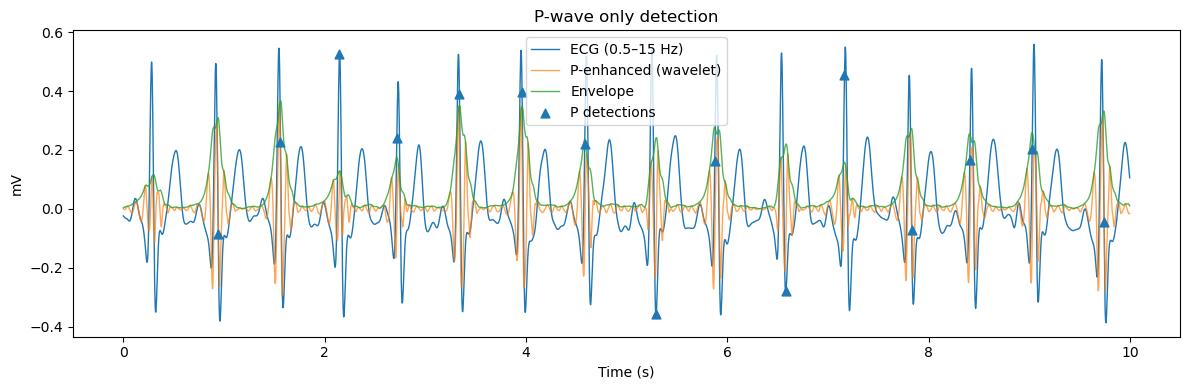

In [468]:
plt.figure(figsize=(12,4))
plt.plot(t, x_bp, lw=1, label='ECG (0.5–15 Hz)')
plt.plot(t, x_p, lw=1, alpha=0.7, label='P-enhanced (wavelet)')
plt.plot(t, p_env, lw=1, alpha=0.8, label='Envelope')
plt.scatter(t[p_idx], x_bp[p_idx], s=40, marker='^', label='P detections', zorder=3)
plt.legend(); plt.xlabel('Time (s)'); plt.ylabel('mV'); plt.title('P-wave only detection')
plt.tight_layout(); plt.show()

Metodo 2 

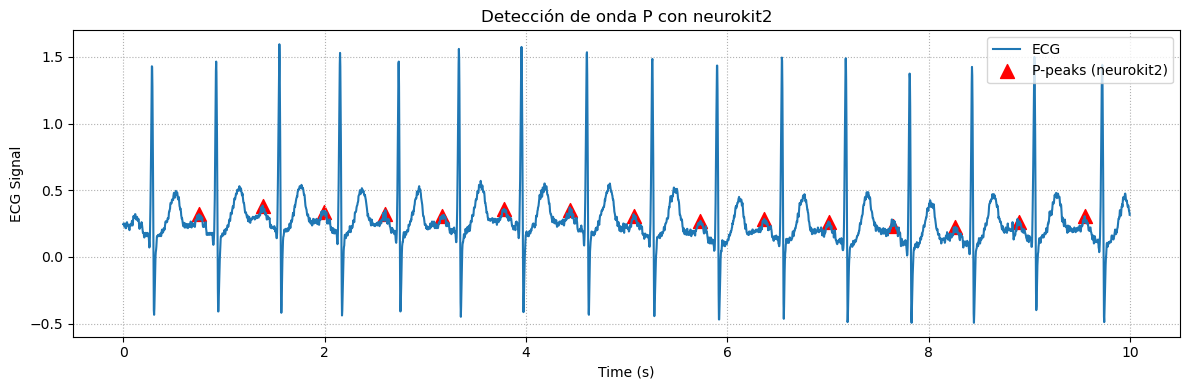

In [469]:
# Detección de la onda P usando neurokit2
signals, info_nk = nk.ecg_process(ecg_signal, sampling_rate=fs)
p_peaks_nk = info_nk["ECG_P_Peaks"]

# Graficar ECG y detecciones de onda P
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[p_peaks_nk], ecg_signal[p_peaks_nk], color='red', marker='^', s=100, label="P-peaks (neurokit2)")
plt.xlabel("Time (s)")
plt.ylabel("ECG Signal")
plt.title("Detección de onda P con neurokit2")
plt.legend()
plt.grid(ls=":")
plt.tight_layout()
plt.show()

sss

In [470]:
def compute_p_wave_metrics(ecg, sampling_rate=360):
    import numpy as np
    import neurokit2 as nk

    # Procesamiento ECG con NeuroKit
    signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)

    # Convertir siempre a arrays NumPy
    p_onsets  = np.array(info["ECG_P_Onsets"], dtype=float)
    p_offsets = np.array(info["ECG_P_Offsets"], dtype=float)
    p_peaks   = np.array(info["ECG_P_Peaks"], dtype=float)

    # Filtrar valores no válidos (nan)
    valid = (~np.isnan(p_onsets)) & (~np.isnan(p_offsets)) & (~np.isnan(p_peaks))

    p_onsets  = p_onsets[valid]
    p_offsets = p_offsets[valid]
    p_peaks   = p_peaks[valid]

    if len(p_onsets) == 0:
        return None

    # -------- 1. Duración de la onda P (ms)
    durations = (p_offsets - p_onsets) * (1000 / sampling_rate)

    # -------- 2. Amplitud CORREGIDA con baseline local
    amplitudes = []
    for p in p_peaks.astype(int):

        # Ventana para baseline: 40–10 ms antes del pico P
        win_start = max(p - int(0.040 * sampling_rate), 0)
        win_end   = max(p - int(0.010 * sampling_rate), 1)

        baseline = np.mean(ecg[win_start:win_end])
        amplitude = ecg[p] - baseline
        amplitudes.append(amplitude)

    amplitudes = np.array(amplitudes) 

    # -------- 3. Dispersión de la onda P
    PWD = np.max(durations) - np.min(durations)

    results = {
        "P_durations_ms": durations,
        "P_amplitudes_mV": amplitudes,
        "P_wave_dispersion_ms": PWD,
        "mean_duration_ms": np.mean(durations),
        "mean_amplitude_mV": np.mean(amplitudes)
    }

    return results
metrics = compute_p_wave_metrics(ecg_signal, sampling_rate=360)

if metrics is None:
    print("No se detectaron ondas P válidas.")
else:
    print("===== MÉTRICAS DE LA ONDA P =====")
    print("Duraciones (ms):", np.round(metrics["P_durations_ms"], 2))
    print("Amplitudes (mV):", np.round(metrics["P_amplitudes_mV"], 3))

    print("\n--- Estadísticos ---")
    print(f"Duración promedio (ms): {metrics['mean_duration_ms']:.2f}")
    print(f"Amplitud promedio (mV): {metrics['mean_amplitude_mV']:.3f}")
    print(f"P-wave Dispersion (ms): {metrics['P_wave_dispersion_ms']:.2f}")


===== MÉTRICAS DE LA ONDA P =====
Duraciones (ms): [ 91.67  86.11  91.67  80.56  91.67  86.11 105.56 100.    91.67  83.33
  88.89  88.89  94.44  77.78  86.11]
Amplitudes (mV): [0.042 0.057 0.03  0.04  0.04  0.049 0.047 0.05  0.033 0.056 0.055 0.01
 0.05  0.042 0.066]

--- Estadísticos ---
Duración promedio (ms): 89.63
Amplitud promedio (mV): 0.044
P-wave Dispersion (ms): 27.78


s

In [471]:
def moving_average(x, w):
    w = max(1, int(w))
    c = np.ones(w) / w
    return np.convolve(x, c, mode='same')


def _refine_peak(ecg, idx, half_win):
    """Refine approximate peak to the max of the raw ECG in ±half_win."""
    i0 = max(0, idx-half_win); i1 = min(len(ecg), idx+half_win+1)
    if i1-i0 <= 1: 
        return idx
    return i0 + np.argmax(ecg[i0:i1])

d

In [472]:
def detect_qrs_rpeaks(ecg, fs):
    """
    Returns r_peaks (sample indices), qrs_on (onsets), qrs_off (offsets).
    Method: bandpass(5–15 Hz) → derivative → square → MWI(150 ms) → adaptive threshold.
    """
    # Emphasize QRS bandwidth
    #qrs_bp = bandpass(ecg, fs, low=5.0, high=15.0, order=3)

    # PT-style preprocessing
    #der = np.append(np.diff(qrs_bp), 0)                    # derivative
    der = np.append(np.diff(ecg), 0)                    # derivative
    sq = der**2                                            # nonlinearity
    mwi = moving_average(sq, int(0.150*fs))                # ~150 ms integration

    # Adaptive threshold based on robust stats
    thr = np.median(mwi) + 1.5*np.median(np.abs(mwi - np.median(mwi)))  # median + 1.5*MAD

    # Refractory period ~200 ms to avoid double detections
    min_dist = int(0.2 * fs)
    pk_idx, _ = find_peaks(mwi, height=thr, distance=min_dist)

    # Refine each detection to true R on band-limited ECG (steeper & higher than raw)
    #r_peaks = np.array([_refine_peak(qrs_bp, p, half_win=int(0.05*fs)) for p in pk_idx], dtype=int)
    r_peaks = np.array([_refine_peak(ecg, p, half_win=int(0.05*fs)) for p in pk_idx], dtype=int)

    # QRS onset/offset from energy curve around each R
    qrs_on = []
    qrs_off = []
    half = int(0.12 * fs)  # ±120 ms search
    for r in r_peaks:
        i0 = max(0, r - half); i1 = min(len(mwi), r + half)
        seg = mwi[i0:i1]
        # define a local, conservative threshold
        loc_thr = np.median(seg)
        # onset: last index from r backwards where energy falls below local threshold
        on = i0 + np.where(seg[:(r-i0)][::-1] < loc_thr)[0]
        on = r - on[0] if len(on) else i0
        # offset: first index after r where energy falls below local threshold
        off = i0 + (np.where(seg[(r-i0):] < loc_thr)[0][0] if np.any(seg[(r-i0):] < loc_thr) else (i1 - i0 - 1))
        qrs_on.append(int(on))
        qrs_off.append(int(off))
    return r_peaks, np.array(qrs_on), np.array(qrs_off) 

s

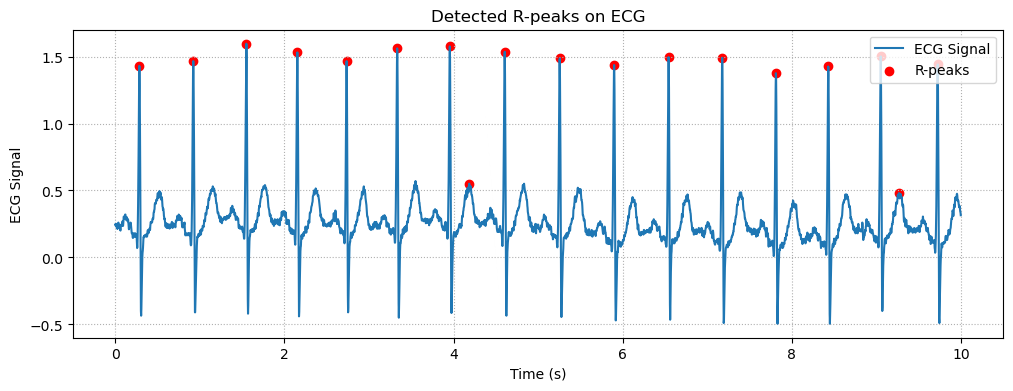

In [473]:
# Detect QRS peaks and boundaries
r_peaks, qrs_on, qrs_off = detect_qrs_rpeaks(ecg_signal, fs)

# Plot ECG signal and detected R-peaks
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label='ECG Signal')
plt.scatter(t[r_peaks], ecg_signal[r_peaks], color='red', label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('ECG Signal')
plt.title('Detected R-peaks on ECG')
plt.legend()
plt.grid(ls=":")
plt.show()

d

In [474]:
def rr_intervals_ms(r_peaks, fs):
    """Return RR intervals in milliseconds and heart rate series in bpm."""
    if len(r_peaks) < 2:
        return np.array([]), np.array([])
    rr_ms = np.diff(r_peaks) * 1000.0 / fs
    hr_bpm = 60_000.0 / rr_ms
    return rr_ms, hr_bpm 

QRS

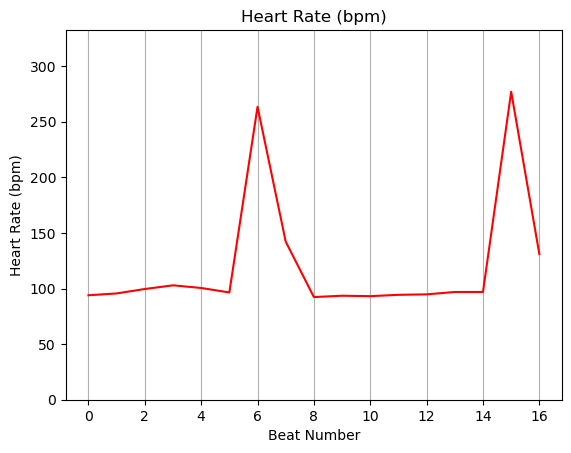

In [475]:
rr_ms, hr_bpm = rr_intervals_ms(r_peaks, fs) 
plt.plot(hr_bpm, c='red')
plt.title('Heart Rate (bpm)')
plt.xlabel('Beat Number')
plt.ylabel('Heart Rate (bpm)')
plt.ylim(0, max(hr_bpm)*1.2)
plt.grid(axis='x')
plt.show()

Metricas

In [476]:
# ===== 1. Función de intervalos RR =====
def rr_intervals_ms(r_peaks, fs):
    """Return RR intervals in milliseconds and heart rate series in bpm."""
    if len(r_peaks) < 2:
        return np.array([]), np.array([])
    rr_ms = np.diff(r_peaks) * 1000.0 / fs      # RR en milisegundos
    hr_bpm = 60_000.0 / rr_ms                   # BPM
    return rr_ms, hr_bpm


sd

In [477]:
# ===== 2. Calcular intervalos RR y BPM =====
rr_ms, hr_bpm = rr_intervals_ms(r_peaks, fs)


# ===== 3. Imprimir métricas =====
if len(rr_ms) > 0:
    print("\n===== MÉTRICAS DE INTERVALOS RR =====")
    print("RR intervalos (ms):", np.round(rr_ms, 2))
    print(f"RR promedio (ms): {np.mean(rr_ms):.2f}")

    print("\n===== MÉTRICAS DE RITMO CARDIACO =====")
    print("BPM instantáneos:", np.round(hr_bpm, 2))
    print(f"BPM promedio:     {np.mean(hr_bpm):.2f}")
    print("============================================\n")
else:
    print("No se pudieron calcular intervalos RR.")



===== MÉTRICAS DE INTERVALOS RR =====
RR intervalos (ms): [638.89 627.78 602.78 583.33 597.22 622.22 227.78 422.22 650.   641.67
 644.44 636.11 633.33 619.44 619.44 216.67 458.33]
RR promedio (ms): 555.39

===== MÉTRICAS DE RITMO CARDIACO =====
BPM instantáneos: [ 93.91  95.58  99.54 102.86 100.47  96.43 263.41 142.11  92.31  93.51
  93.1   94.32  94.74  96.86  96.86 276.92 130.91]
BPM promedio:     121.40



lk

In [478]:
fs = 360  # frecuencia de muestreo

# Procesa automáticamente toda la señal
signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)

# R-peaks detectados
r_peaks = info["ECG_R_Peaks"]

print("R-peaks detectados:", len(r_peaks))

R-peaks detectados: 15


as

R-peaks detectados: 15


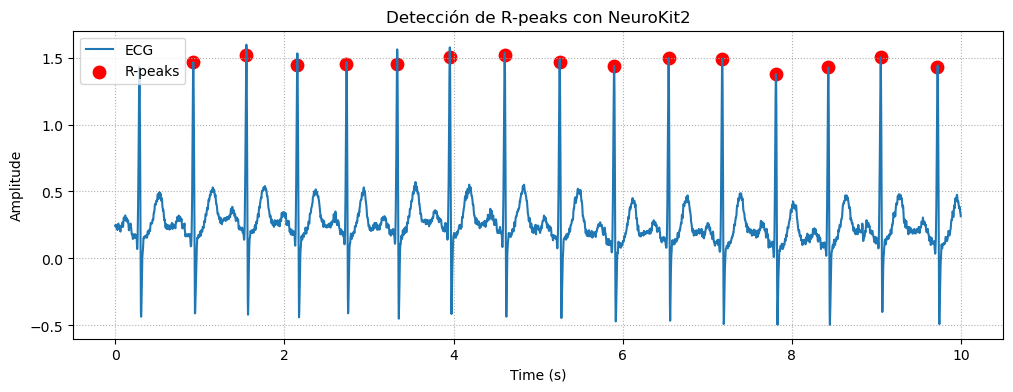


===== MÉTRICAS RR Y FRECUENCIA CARDIACA =====
RR intervals (ms): [625.   602.78 583.33 597.22 622.22 650.   650.   644.44 644.44 633.33
 636.11 619.44 619.44 672.22]
RR mean (ms): 628.57

Heart Rate (bpm): [ 96.    99.54 102.86 100.47  96.43  92.31  92.31  93.1   93.1   94.74
  94.32  96.86  96.86  89.26]
HR mean (bpm): 95.58


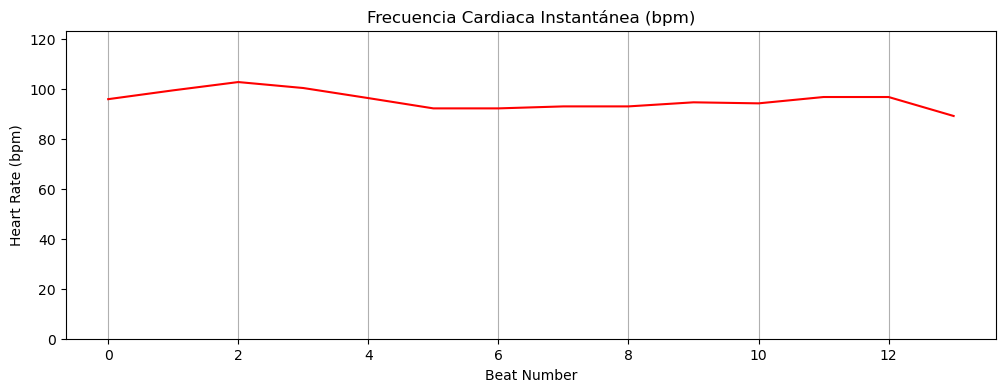

In [479]:
fs = 360  # Frecuencia de muestreo

# -------------------------
# 1) Procesar señal con NeuroKit2
# -------------------------
signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)

# R-peaks detectados
r_peaks = info["ECG_R_Peaks"]

print("R-peaks detectados:", len(r_peaks))

# -------------------------
# 2) Graficar R-peaks
# -------------------------
t = np.arange(len(ecg_signal)) / fs

plt.figure(figsize=(12,4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[r_peaks], ecg_signal[r_peaks], color="red", s=80, label="R-peaks")
plt.title("Detección de R-peaks con NeuroKit2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(ls=":")
plt.show()


# -------------------------
# 3) Función RR y HR
# -------------------------
def rr_intervals_ms(r_peaks, fs):
    """Return RR intervals in ms and heart rate series in bpm."""
    if len(r_peaks) < 2:
        return np.array([]), np.array([])
    rr_ms = np.diff(r_peaks) * (1000.0 / fs)   # RR en ms
    hr_bpm = 60000.0 / rr_ms                   # FC instantánea
    return rr_ms, hr_bpm


# -------------------------
# 4) Calcular RR y HR
# -------------------------
rr_ms, hr_bpm = rr_intervals_ms(r_peaks, fs)

# -------------------------
# 5) Mostrar métricas
# -------------------------
if len(rr_ms) == 0:
    print("No se pueden calcular RR ni BPM (muy pocos R-peaks).")
else:
    print("\n===== MÉTRICAS RR Y FRECUENCIA CARDIACA =====")
    print("RR intervals (ms):", np.round(rr_ms, 2))
    print("RR mean (ms):", np.round(np.mean(rr_ms), 2))

    print("\nHeart Rate (bpm):", np.round(hr_bpm, 2))
    print("HR mean (bpm):", np.round(np.mean(hr_bpm), 2))


# -------------------------
# 6) Gráfica de HR instantáneo
# -------------------------
plt.figure(figsize=(12,4))
plt.plot(hr_bpm, c='red')
plt.title('Frecuencia Cardiaca Instantánea (bpm)')
plt.xlabel('Beat Number')
plt.ylabel('Heart Rate (bpm)')
plt.ylim(0, max(hr_bpm) * 1.2)
plt.grid(axis='x')
plt.show()

asdasd

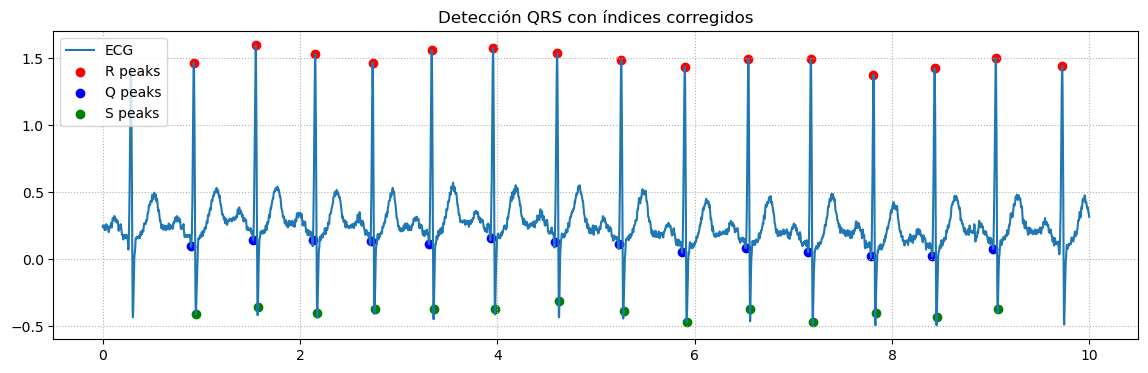

In [480]:
def clean_indices(idx):
    if idx is None:
        return []
    idx = np.array(idx)
    idx = idx[np.isfinite(idx)]               
    idx = idx[idx >= 0]
    idx = idx[idx < len(ecg_signal)]          
    idx = idx.astype(int)
    return idx

# 1) Detectar R-peaks
signals, r_info = nk.ecg_peaks(ecg_signal, sampling_rate=fs)
r_peaks = clean_indices(r_info["ECG_R_Peaks"])

# 2) Delineado
delineate_signal, delineate_info = nk.ecg_delineate(
    ecg_signal,
    r_peaks,
    sampling_rate=fs,
    method="dwt"
)

# 3) Extraer + limpiar
q_peaks   = clean_indices(delineate_info.get("ECG_Q_Peaks", []))
s_peaks   = clean_indices(delineate_info.get("ECG_S_Peaks", []))
q_onsets  = clean_indices(delineate_info.get("ECG_Q_Onsets", []))
s_offsets = clean_indices(delineate_info.get("ECG_S_Offsets", []))

# 4) Graficar
plt.figure(figsize=(14, 4))
plt.plot(t, ecg_signal, label="ECG")

plt.scatter(t[r_peaks], ecg_signal[r_peaks], c="red", label="R peaks")

if len(q_peaks) > 0:
    plt.scatter(t[q_peaks], ecg_signal[q_peaks], c="blue", label="Q peaks")

if len(s_peaks) > 0:
    plt.scatter(t[s_peaks], ecg_signal[s_peaks], c="green", label="S peaks")

plt.legend()
plt.grid(ls=":")
plt.title("Detección QRS con índices corregidos")
plt.show()


DS

In [481]:
# ----------------------------------
# 1) Procesamiento ECG y R-peaks
# ----------------------------------
signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)
r_peaks = info["ECG_R_Peaks"]

# ----------------------------------
# 2) Delineado completo (CWT)
# ----------------------------------
_, d_info = nk.ecg_delineate(
    ecg_signal, 
    r_peaks, 
    sampling_rate=fs,
    method="dwt"
)

# ----------------------------------
# 3) Extraer onsets y offsets del complejo QRS
# ----------------------------------
qrs_onsets  = np.array(d_info["ECG_R_Onsets"], dtype=float)
qrs_offsets = np.array(d_info["ECG_R_Offsets"], dtype=float)

# Eliminar NaN o índices inválidos
valid = ~np.isnan(qrs_onsets) & ~np.isnan(qrs_offsets)

qrs_onsets  = qrs_onsets[valid]
qrs_offsets = qrs_offsets[valid]

# ----------------------------------
# 4) Duración del QRS (ms)
# ----------------------------------
duraciones_ms = (qrs_offsets - qrs_onsets) * (1000 / fs)

# ----------------------------------
# 5) Amplitud del QRS (mV)
# ----------------------------------
amplitudes = []
for ini, fin in zip(qrs_onsets, qrs_offsets):
    ventana = ecg_signal[int(ini):int(fin)]
    amplitudes.append(ventana.max() - ventana.min())

amplitudes = np.array(amplitudes)

# ----------------------------------
# 6) Impresión
# ----------------------------------
print("Duraciones QRS (ms):", np.round(duraciones_ms, 2))
print("Amplitudes QRS (mV):", np.round(amplitudes, 3), "\n")

print("---- Estadísticos ----")
print(f"Duración QRS promedio : {duraciones_ms.mean():6.2f} ms")
print(f"Amplitud QRS promedio : {amplitudes.mean():6.3f} mV")
print(f"Duración QRS mínima   : {duraciones_ms.min():6.2f} ms")
print(f"Duración QRS máxima   : {duraciones_ms.max():6.2f} ms")
print(f"N° latidos analizados : {len(duraciones_ms)}")



Duraciones QRS (ms): [83.33 77.78 75.   72.22 80.56 80.56 75.   83.33 80.56 75.   77.78 77.78
 80.56 75.  ]
Amplitudes QRS (mV): [1.875 2.015 1.97  1.875 2.01  1.99  1.97  1.93  1.905 1.96  1.98  1.87
 1.92  1.9  ] 

---- Estadísticos ----
Duración QRS promedio :  78.17 ms
Amplitud QRS promedio :  1.941 mV
Duración QRS mínima   :  72.22 ms
Duración QRS máxima   :  83.33 ms
N° latidos analizados : 14


Onda T

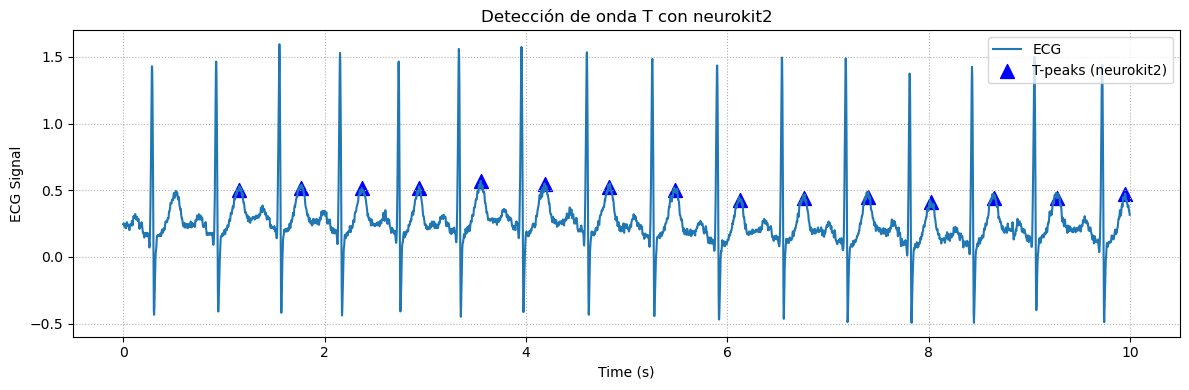

In [482]:
# Detección de la onda T usando neurokit2
signals, info_nk = nk.ecg_process(ecg_signal, sampling_rate=fs)
p_peaks_nk = info_nk["ECG_T_Peaks"]

# Graficar ECG y detecciones de onda T
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[p_peaks_nk], ecg_signal[p_peaks_nk], color='blue', marker='^', s=100, label="T-peaks (neurokit2)")
plt.xlabel("Time (s)")
plt.ylabel("ECG Signal")
plt.title("Detección de onda T con neurokit2")
plt.legend()
plt.grid(ls=":")
plt.tight_layout()
plt.show()

ds

In [483]:
def compute_t_wave_metrics(ecg, sampling_rate):
    """
    Compute T-wave duration, amplitude (with baseline correction), 
    and TpTe interval using NeuroKit2 detections.
    """

    # -----------------------------------------
    # Procesamiento con NeuroKit2
    # -----------------------------------------
    signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)

    # Extraer detecciones
    t_onsets  = np.array(info["ECG_T_Onsets"], dtype=float)
    t_peaks   = np.array(info["ECG_T_Peaks"], dtype=float)
    t_offsets = np.array(info["ECG_T_Offsets"], dtype=float)

    # Filtrar valores válidos
    valid = (~np.isnan(t_onsets)) & (~np.isnan(t_peaks)) & (~np.isnan(t_offsets))
    t_onsets  = t_onsets[valid]
    t_peaks   = t_peaks[valid]
    t_offsets = t_offsets[valid]

    if len(t_peaks) == 0:
        print("No se detectaron ondas T válidas.")
        return None

    # -----------------------------------------
    # 1. Duración de la onda T (ms)
    # -----------------------------------------
    t_durations = (t_offsets - t_onsets) * (1000.0 / sampling_rate)

    # -----------------------------------------
    # 2. Amplitud T REAL: T_peak - baseline local
    # -----------------------------------------
    t_amplitudes = []
    pre_start = int(0.04 * sampling_rate)   # 40 ms antes del pico T
    pre_end   = int(0.01 * sampling_rate)   # hasta 10 ms antes

    for tp in t_peaks.astype(int):

        if tp - pre_start < 0:
            continue  # evitar índices negativos
        
        baseline = np.mean(ecg[tp - pre_start : tp - pre_end])
        amp = ecg[tp] - baseline

        t_amplitudes.append(amp)

    t_amplitudes = np.array(t_amplitudes)

    # -----------------------------------------
    # 3. Intervalo TpTe (ms)
    # -----------------------------------------
    tpte = (t_offsets - t_peaks) * (1000.0 / sampling_rate)

    # -----------------------------------------
    # Empaquetar resultados
    # -----------------------------------------
    return {
        "T_durations_ms": t_durations,
        "T_amplitudes_mV": t_amplitudes,
        "TpTe_ms": tpte,
        "mean_T_duration_ms": np.mean(t_durations),
        "mean_T_amplitude_mV": np.mean(t_amplitudes),
        "mean_TpTe_ms": np.mean(tpte)
    }


ddd

In [484]:
# --------------------------------
# EJECUCIÓN
# --------------------------------

metrics_T = compute_t_wave_metrics(ecg_signal, sampling_rate=fs)

if metrics_T is not None:
    print("===== MÉTRICAS DE LA ONDA T =====")
    print("Duraciones T (ms):", np.round(metrics_T["T_durations_ms"], 2))
    print("Amplitudes T (mV):", np.round(metrics_T["T_amplitudes_mV"], 3))
    print("TpTe (ms):", np.round(metrics_T["TpTe_ms"], 2))

    print("\n--- Estadísticos ---")
    print(f"Duración T promedio (ms): {metrics_T['mean_T_duration_ms']:.2f}")
    print(f"Amplitud T promedio (mV): {metrics_T['mean_T_amplitude_mV']:.3f}")
    print(f"TpTe promedio (ms): {metrics_T['mean_TpTe_ms']:.2f}")

===== MÉTRICAS DE LA ONDA T =====
Duraciones T (ms): [191.67 177.78 161.11 125.   180.56 172.22 130.56 116.67 166.67 194.44
 169.44 183.33 155.56 213.89]
Amplitudes T (mV): [0.029 0.026 0.05  0.067 0.076 0.064 0.045 0.04  0.03  0.031 0.016 0.05
 0.014 0.014]
TpTe (ms): [ 80.56  80.56  69.44  61.11  75.    69.44  66.67  83.33  72.22  66.67
  77.78  75.    88.89 158.33]

--- Estadísticos ---
Duración T promedio (ms): 167.06
Amplitud T promedio (mV): 0.039
TpTe promedio (ms): 80.36
